# Cargar recursos

In [1]:
#Cargar recursos y preparar entorno
#En esta sección se configuran los recursos iniciales para el trabajo, incluyendo autenticación con Kaggle y descarga de datos.

#archivo de inicialización desde el repositorio del curso
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/ai4eng.v1/main/content/init.py
import init; init.init(force_download=False); init.get_weblink()

replicating local resources


In [2]:
from google.colab import files # Cargar archivo kaggle.json para autenticarse
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"luzyramirez","key":"ea1df442e687202a0846fe0c3a0f47ce"}'}

In [3]:
# Aqui se configuran los permisos de Kaggle
import os
os.environ['KAGGLE_CONFIG_DIR'] = '.'
!chmod 600 ./kaggle.json
!kaggle competitions download -c udea-ai-4-eng-20251-pruebas-saber-pro-colombia


  0% 0.00/29.9M [00:00<?, ?B/s]
100% 29.9M/29.9M [00:00<00:00, 1.18GB/s]


In [4]:
!unzip udea*.zip > /dev/null

In [5]:
!wc *.csv # Ver cuántos datos hay en cada archivo

   296787    296787   4716673 submission_example.csv
   296787   4565553  59185250 test.csv
   692501  10666231 143732449 train.csv
  1286075  15528571 207634372 total


In [6]:
# Carga de datos
# aqui se carga el conjunto de entrenamiento y se realiza una primera exploración para poder entender su estructura.


import pandas as pd
import numpy as np

z = pd.read_csv("train.csv")
print ("shape of loaded dataframe", z.shape)

shape of loaded dataframe (692500, 21)


In [7]:

import matplotlib.pyplot as plt

In [8]:
z.head()

,ID,PERIODO,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_TIENELAVADORA,...,ESTU_PRIVADO_LIBERTAD,ESTU_PAGOMATRICULAPROPIO,FAMI_TIENECOMPUTADOR,FAMI_TIENEINTERNET.1,FAMI_EDUCACIONMADRE,RENDIMIENTO_GLOBAL,coef_1,coef_2,coef_3,coef_4
0,904256,20212,ENFERMERIA,BOGOTÁ,Entre 5.5 millones y menos de 7 millones,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica incompleta,Si,...,N,No,Si,Si,Postgrado,medio-alto,0.322,0.208,0.310,0.267
1,645256,20212,DERECHO,ATLANTICO,Entre 2.5 millones y menos de 4 millones,0,Estrato 3,No,Técnica o tecnológica completa,Si,...,N,No,Si,No,Técnica o tecnológica incompleta,bajo,0.311,0.215,0.292,0.264
2,308367,20203,MERCADEO Y PUBLICIDAD,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Si,...,N,No,No,Si,Secundaria (Bachillerato) completa,bajo,0.297,0.214,0.305,0.264
3,470353,20195,ADMINISTRACION DE EMPRESAS,SANTANDER,Entre 4 millones y menos de 5.5 millones,0,Estrato 4,Si,No sabe,Si,...,N,No,Si,Si,Secundaria (Bachillerato) completa,alto,0.485,0.172,0.252,0.190
4,989032,20212,PSICOLOGIA,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 3,Si,Primaria completa,Si,...,N,No,Si,Si,Primaria completa,medio-bajo,0.316,0.232,0.285,0.294


# Preprocesado de datos
En base a la exploracion de los datos, nosotros decidimos trabajar con las siguientes columnas:

-PAGO MATRICULA PROPIO

-FAMI_EDUCACIONPADRE

RENDIMIENTO_GLOBAL

In [9]:
# Preprocesamiento de datos
# en esta parte se seleccionan y agrupan las variables de interés y se manejan valores nulos.


datos = z[['ESTU_PAGOMATRICULAPROPIO', 'FAMI_EDUCACIONPADRE','RENDIMIENTO_GLOBAL']]
datos.head()

,ESTU_PAGOMATRICULAPROPIO,FAMI_EDUCACIONPADRE,RENDIMIENTO_GLOBAL
0,No,Técnica o tecnológica incompleta,medio-alto
1,No,Técnica o tecnológica completa,bajo
2,No,Secundaria (Bachillerato) completa,bajo
3,No,No sabe,alto
4,No,Primaria completa,medio-bajo


Limpieza de datos nulos

In [10]:
sum(datos.ESTU_PAGOMATRICULAPROPIO.isna()), sum(datos.FAMI_EDUCACIONPADRE.isna()) # Revisar valores nulos en cada variable

(6498, 23178)

In [11]:
# Aca se remplazan los valores nulos por 'no info' en variables categóricas
datos.ESTU_PAGOMATRICULAPROPIO.values[datos.ESTU_PAGOMATRICULAPROPIO.isna()] = 'no info'
datos.FAMI_EDUCACIONPADRE.values[datos.FAMI_EDUCACIONPADRE.isna()] = 'no info'
sum(datos.ESTU_PAGOMATRICULAPROPIO.isna()), sum(datos.FAMI_EDUCACIONPADRE.isna())

(0, 0)

Limpieza de FAMI_EDUCACIONPADRE

In [12]:
datos = datos.copy()

#Se unifican las respuestas `'No sabe'` y `'No Aplica'` bajo la categoría `'no info'`, ya que ambas representan ausencia de información útil sobre el nivel educativo del padre.
datos.FAMI_EDUCACIONPADRE = ['no info' if i in ['No sabe', 'No Aplica'] else i for i in datos.FAMI_EDUCACIONPADRE.values]

In [13]:
datos.FAMI_EDUCACIONPADRE.value_counts()

,count
FAMI_EDUCACIONPADRE,
Secundaria (Bachillerato) completa,128289
Primaria incompleta,125675
Educación profesional completa,83117
Secundaria (Bachillerato) incompleta,71654
Técnica o tecnológica completa,62995
Primaria completa,55958
no info,48999
Postgrado,44169
Educación profesional incompleta,27084


In [14]:
x = datos.FAMI_EDUCACIONPADRE.values # Obtener los valores actuales de la columna como array
FAMI_EDUCACIONPADRE_vals = sorted(np.unique(x))
FAMI_EDUCACIONPADRE_onehot_vals = {val: np.eye(len(FAMI_EDUCACIONPADRE_vals))[i] for i,val in enumerate(FAMI_EDUCACIONPADRE_vals)} # Crear un diccionario que asigna a cada categoría su vector one-hot
FAMI_EDUCACIONPADRE_onehot_vals # Aqui se visualiza el diccionario resultante para verificar la codificación

{'Educación profesional completa': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'Educación profesional incompleta': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'Ninguno': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'Postgrado': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
 'Primaria completa': array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
 'Primaria incompleta': array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
 'Secundaria (Bachillerato) completa': array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 'Secundaria (Bachillerato) incompleta': array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]),
 'Técnica o tecnológica completa': array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]),
 'Técnica o tecnológica incompleta': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
 'no info': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])}

In [15]:
FAMI_EDUCACIONPADRE_onehot_enc = np.r_[[FAMI_EDUCACIONPADRE_onehot_vals[i] for i in datos.FAMI_EDUCACIONPADRE]] # Aplicar el diccionario de codificación a cada fila del DataFrame
FAMI_EDUCACIONPADRE_onehot_enc # Ver las primeras filas del array codificado

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [16]:
FAMI_EDUCACIONPADRE_df = pd.DataFrame(FAMI_EDUCACIONPADRE_onehot_enc, columns=[f"FAMI_EDUCACIONPADRE__{v}" for v in FAMI_EDUCACIONPADRE_onehot_vals]) # Crear un nuevo DataFrame a partir de la codificación
FAMI_EDUCACIONPADRE_df  # Mostrar el DataFrame resultante

,FAMI_EDUCACIONPADRE__Educación profesional completa,FAMI_EDUCACIONPADRE__Educación profesional incompleta,FAMI_EDUCACIONPADRE__Ninguno,FAMI_EDUCACIONPADRE__Postgrado,FAMI_EDUCACIONPADRE__Primaria completa,FAMI_EDUCACIONPADRE__Primaria incompleta,FAMI_EDUCACIONPADRE__Secundaria (Bachillerato) completa,FAMI_EDUCACIONPADRE__Secundaria (Bachillerato) incompleta,FAMI_EDUCACIONPADRE__Técnica o tecnológica completa,FAMI_EDUCACIONPADRE__Técnica o tecnológica incompleta,FAMI_EDUCACIONPADRE__no info
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
692495,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
692496,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
692497,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
692498,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Limpieza de pago matricula Propio

In [17]:
y = datos.ESTU_PAGOMATRICULAPROPIO.values
ESTU_PAGOMATRICULAPROPIO_vals = sorted(np.unique(y))
ESTU_PAGOMATRICULAPROPIO_onehot_vals = {val: np.eye(len(ESTU_PAGOMATRICULAPROPIO_vals))[i] for i,val in enumerate(ESTU_PAGOMATRICULAPROPIO_vals)} # Crear diccionario de codificación one-hot
ESTU_PAGOMATRICULAPROPIO_onehot_vals # Ver la codificación asignada a cada categoría

{'No': array([1., 0., 0.]),
 'Si': array([0., 1., 0.]),
 'no info': array([0., 0., 1.])}

In [18]:
ESTU_PAGOMATRICULAPROPIO_onehot_enc = np.r_[[ESTU_PAGOMATRICULAPROPIO_onehot_vals[i] for i in datos.ESTU_PAGOMATRICULAPROPIO]] # Aplicar la codificación a cada registro
ESTU_PAGOMATRICULAPROPIO_onehot_enc

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [19]:
ESTU_PAGOMATRICULAPROPIO_df = pd.DataFrame(ESTU_PAGOMATRICULAPROPIO_onehot_enc, columns=[f"ESTU_PAGOMATRICULAPROPIO__{v}" for v in ESTU_PAGOMATRICULAPROPIO_onehot_vals]) # Se crea un nuevo DataFrame a partir del resultado codificado
ESTU_PAGOMATRICULAPROPIO_df # Mostrar las primeras filas del nuevo DataFrame

,ESTU_PAGOMATRICULAPROPIO__No,ESTU_PAGOMATRICULAPROPIO__Si,ESTU_PAGOMATRICULAPROPIO__no info
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
...,...,...,...
692495,0.0,1.0,0.0
692496,1.0,0.0,0.0
692497,0.0,1.0,0.0
692498,0.0,1.0,0.0


In [20]:
datos = pd.concat([FAMI_EDUCACIONPADRE_df, datos], axis=1).drop('FAMI_EDUCACIONPADRE', axis=1) # Agregar columnas codificadas de FAMI_EDUCACIONPADRE al DataFrame principal
datos.shape # Verificar  DataFrame

(692500, 13)

In [21]:
datos = pd.concat([ESTU_PAGOMATRICULAPROPIO_df, datos], axis=1).drop('ESTU_PAGOMATRICULAPROPIO', axis=1) # Se agregan columnas codificadas de ESTU_PAGOMATRICULAPROPIO al DataFrame principal
datos.shape

(692500, 15)

In [22]:
datos.head() #visuaizar dataframe resultante

,ESTU_PAGOMATRICULAPROPIO__No,ESTU_PAGOMATRICULAPROPIO__Si,ESTU_PAGOMATRICULAPROPIO__no info,FAMI_EDUCACIONPADRE__Educación profesional completa,FAMI_EDUCACIONPADRE__Educación profesional incompleta,FAMI_EDUCACIONPADRE__Ninguno,FAMI_EDUCACIONPADRE__Postgrado,FAMI_EDUCACIONPADRE__Primaria completa,FAMI_EDUCACIONPADRE__Primaria incompleta,FAMI_EDUCACIONPADRE__Secundaria (Bachillerato) completa,FAMI_EDUCACIONPADRE__Secundaria (Bachillerato) incompleta,FAMI_EDUCACIONPADRE__Técnica o tecnológica completa,FAMI_EDUCACIONPADRE__Técnica o tecnológica incompleta,FAMI_EDUCACIONPADRE__no info,RENDIMIENTO_GLOBAL
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,medio-alto
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,bajo
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,bajo
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,alto
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,medio-bajo


Limpieza de RENDIMIENTO_GLOBAL

In [23]:
y = 'RENDIMIENTO_GLOBAL' # Diccionario de codificación

rg = { 'bajo':0, 'medio-bajo':1, 'medio-alto':2, 'alto': 3}
datos[y] = [rg[i] for i in datos[y]] # Se remplazan los valores categóricos por sus equivalentes numéricos

In [24]:
datos.head() #Se visualizan las primeras filas

,ESTU_PAGOMATRICULAPROPIO__No,ESTU_PAGOMATRICULAPROPIO__Si,ESTU_PAGOMATRICULAPROPIO__no info,FAMI_EDUCACIONPADRE__Educación profesional completa,FAMI_EDUCACIONPADRE__Educación profesional incompleta,FAMI_EDUCACIONPADRE__Ninguno,FAMI_EDUCACIONPADRE__Postgrado,FAMI_EDUCACIONPADRE__Primaria completa,FAMI_EDUCACIONPADRE__Primaria incompleta,FAMI_EDUCACIONPADRE__Secundaria (Bachillerato) completa,FAMI_EDUCACIONPADRE__Secundaria (Bachillerato) incompleta,FAMI_EDUCACIONPADRE__Técnica o tecnológica completa,FAMI_EDUCACIONPADRE__Técnica o tecnológica incompleta,FAMI_EDUCACIONPADRE__no info,RENDIMIENTO_GLOBAL
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1


# Construcción del modelo

In [25]:
datos = datos[sorted(datos.columns)] # Reordenar las columnas alfabéticamente para mantener consistencia
# Separar variables independientes (X) y la variable objetivo (Y)
X = datos[[c for c in datos.columns if c!=y]].values
Y = datos[y].values
X.shape, Y.shape # Mostrar dimensiones de X e Y

((692500, 14), (692500,))

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
# Dividir el conjunto de datos en entrenamiento (80%) y prueba (20%)
Xtr, Xts, ytr, yts = train_test_split(X,Y, train_size=0.8)
Xtr.shape, Xts.shape, ytr.shape, yts.shape

((554000, 14), (138500, 14), (554000,), (138500,))

In [28]:
from sklearn.ensemble import RandomForestClassifier # Importar y entrenar un clasificador Random Forest, ell cual se utilizo para este modelo
rf = RandomForestClassifier()
rf.fit(Xtr, ytr)

RandomForestClassifier()

In [29]:
# Realizar predicciones para entrenamiento y prueba
preds_tr = rf.predict(Xtr)
preds_ts = rf.predict(Xts)

In [30]:
print (preds_tr[:10])
print (preds_ts[:10])

[3 3 0 3 3 0 2 0 3 3]
[3 0 0 3 3 0 0 3 3 0]


In [31]:
np.mean(preds_tr==ytr), np.mean(preds_ts==yts) # Calcular precisión del modelo en entrenamiento y prueba

(np.float64(0.3393357400722022), np.float64(0.3389097472924188))

Matriz de confusion

In [32]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from rlxutils import subplots # función para crear múltiples gráficos

In [33]:
# Calcular matriz de confusión para entrenamiento y prueba
cm_tr = confusion_matrix(ytr, preds_tr)
cm_ts = confusion_matrix(yts, preds_ts)

# Normalizar cada fila, osea se dividr por la suma de la fila
cm_tr = cm_tr / cm_tr.sum(axis=1).reshape(-1,1)
cm_ts = cm_ts / cm_ts.sum(axis=1).reshape(-1,1)

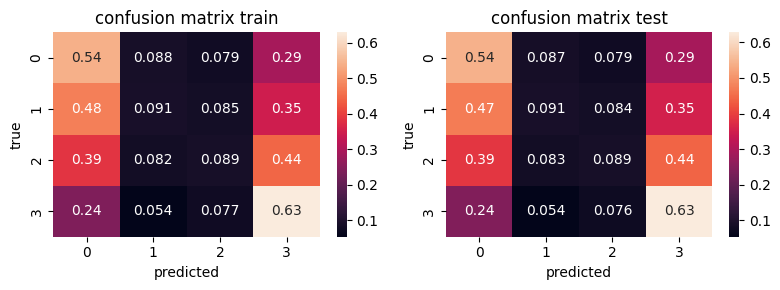

In [34]:
# Visualizar las matrices normalizadas usando mapas de calor
import seaborn as sns
for ax,i in subplots(2, usizex=4):
  if i==0: sns.heatmap(cm_tr, annot=True); plt.title("confusion matrix train")
  if i==1: sns.heatmap(cm_ts, annot=True); plt.title("confusion matrix test")
  plt.ylabel("true")
  plt.xlabel("predicted")